In [1]:
%matplotlib inline  

import warnings
warnings.simplefilter('ignore')

import os
import copy
import time
import numpy as np
import keras.models 
from keras.models import Model
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
import sys; sys.path.append("../")

from config import load_config
from utils import (load_data, preprocess, keras_gcn)
from plot_utils import (draw_chem_activations, plot_image_grid, 
                            create_figs, create_im_arrs)

from methods import (CAM, GradCAM, GradCAMAvg, Gradient, EB, cEB)

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = ""
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [4]:
##Choose dataset
dataset = "BBBP"
#dataset = "BACE"
#dataset = "TOX21"

In [5]:
save_fig = False
save_masks = False

In [6]:
viz = True

In [7]:
### Data
config = load_config(dataset)
data_fp = os.path.join(config['data_dir'], config['data_fn'])
raw_data = load_data(data_fp)
data = preprocess(raw_data)
smiles = raw_data["smiles"]

if dataset == "TOX21":
    dataset_external = dataset + "-NR-ER"
else:
    dataset_external = dataset

label_to_class_name = {0 : "Not {}".format(dataset_external), 
                       1 : "{}".format(dataset_external)}

100%|██████████| 2050/2050 [00:02<00:00, 701.96it/s]


In [8]:
# Model
model_fn = "gcn_{}.h5".format(dataset.lower())
model_fp = os.path.join(config["saved_models_dir"], model_fn)
model = keras_gcn(config)
model.load_weights(model_fp)
num_classes = data['labels_one_hot'].shape[1]

In [9]:
# Select Visualization Data

# #Preselected examples
if dataset == "TOX21":
    
    viz_smiles = ["Nc1ccc(C(=O)Oc2ccccc2)c(O)c1",
                  "Oc1ccc2c(c1)-c1ccccc1C2",
                  "O=C(c1ccccc1)c1ccc(O)c(O)c1O",
                  "Nc1nc(N)nc(-c2ccccc2)n1"]
    
elif dataset == "BBBP":
    
    viz_smiles = ['FC(F)(F)c1ccc(N2CCNCC2)nc1Cl',
                  'FC(F)(F)C(Cl)Br',
                  'FC(F)(F)c1ccc2c(c1)N(CCCN1CCN(C3CC3)CC1)c1ccccc1S2',
                  'FCOC(C(F)(F)F)C(F)(F)F']
    
elif dataset == "BACE": 
    
    viz_smiles = ["COC(Cc1cc(CC2CS(=O)(=O)CC([NH2+]Cc3cccc(C(C)(C)C)c3)C2O)cc(F)c1N)C(F)(F)F",
                  "CCNc1cc(C(=O)NC(Cc2ccccc2)C(O)C[NH2+]C(C)C(=O)NC2CCCCC2)cc(N(c2ccccc2)S(C)(=O)=O)c1",
                  "CCc1cn2c3c(cc(C(=O)NC(Cc4ccccc4)C(O)C[NH2+]C(C)CC)cc13)N(C)S(=O)(=O)CC2",
                  "COc1cccc(C[NH2+]CC(O)C(Cc2cc(F)cc(F)c2)NC(=O)c2cc(C(C)=NOCc3ccccc3)cc(N(C)S(C)(=O)=O)c2)c1"]


viz_data_inds = [np.argwhere(smiles == viz_smile)[0][0] for viz_smile in viz_smiles]
num_to_explain = len(viz_smiles)

In [10]:
#Gather data for viz
viz_data = {}
for k,v in data.items():
    if isinstance(v, np.ndarray):
        vv = v[viz_data_inds]
    elif isinstance(v, list):
        vv = [v[i] for i in viz_data_inds]
    else:
        raise Exception("Data Type Not Supported")
    viz_data[k] = vv

# Explain

In [11]:
###### Explaination Methods

# init
cam = CAM(model)
gcam = GradCAM(model)
gcam_avg = GradCAMAvg(model)
grad = Gradient(model)
eb = EB(model)
ceb = cEB(model)
methods = [grad, eb, ceb, cam, gcam, gcam_avg]
method_names = ["Gradient", "EB", "cEB", "CAM/GradCAM", "GradCAM avg"]

In [12]:
N = len(viz_data['norm_adjs'])

In [13]:
results = []
text = []

for i in range(N):
    A_arr = viz_data['norm_adjs'][i][np.newaxis, :, :]
    X_arr = viz_data['node_features'][i][np.newaxis, :, :]
    Y_arr = viz_data['labels_one_hot'][i]
    smile = viz_smiles[i]

    num_nodes = A_arr.shape[1]
    #forward pass without softmax

    prob = model.predict_on_batch(x=[A_arr, X_arr])
    y_hat = prob.argmax()
    y = Y_arr.argmax()

    # Save prediction info:
    text.append(("%s" %label_to_class_name[y],    # ground truth label
                 "%.2f" % prob.max(),             # probabilistic softmax output  
                 "%s" %label_to_class_name[y_hat] # predicted label
                ))

    results_ = []
    for name,method in zip(method_names, methods):
        mask = method.getMasks([A_arr, X_arr])
        #Normalize
        mask = np.array(mask)
        mask /= mask.max()
        masks_c0, masks_c1 = mask
        results_.append({'weights': masks_c0, 
                         'smile': smile,
                         'method': name,
                         'class': 0})
        results_.append({'weights': masks_c1, 
                         'smile': smile,
                         'method': name,
                         'class': 1})
    results.append(results_)
    
if save_masks:
    results_dir = os.path.join(config["results_dir"], "masks")
    out_fn = "mask_{}.pickle".format(dataset.lower())
    out_fp = os.path.join(results_dir, out_fn)
    if os.path.exists(out_fp):
        with open(out_fp, 'wb') as fh:
            pickle.dump(results, fh, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        print("Masks already exist. Skipping...")

# Visualize

In [14]:
if not viz:
    raise Exception("Stopping viz")

In [15]:
assert len(results) < 100, "Too much data to visualize."

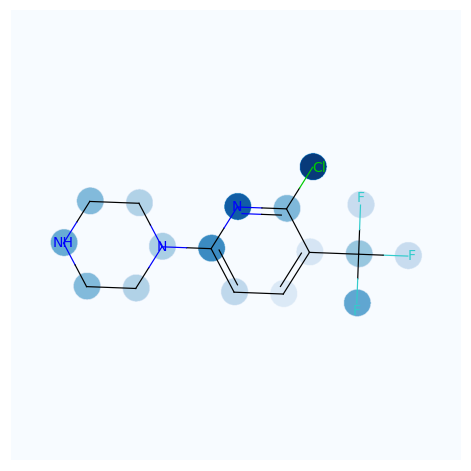

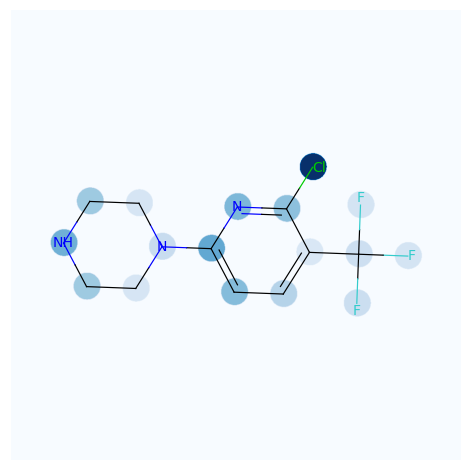

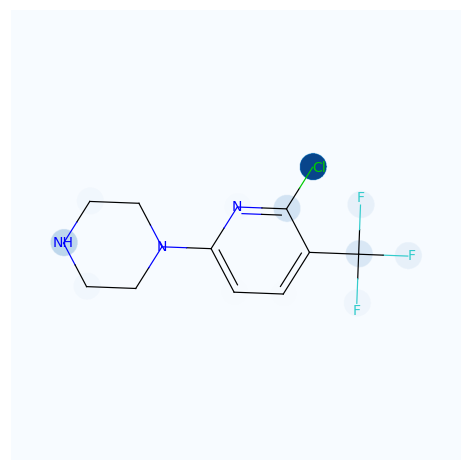

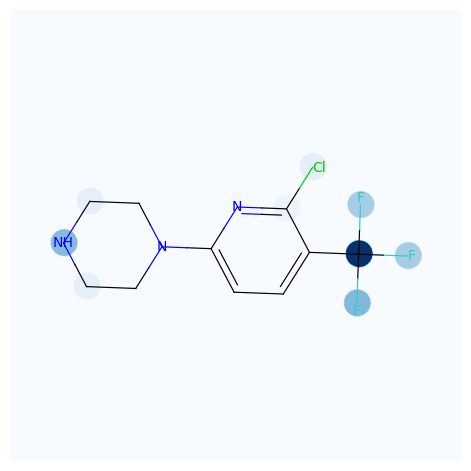

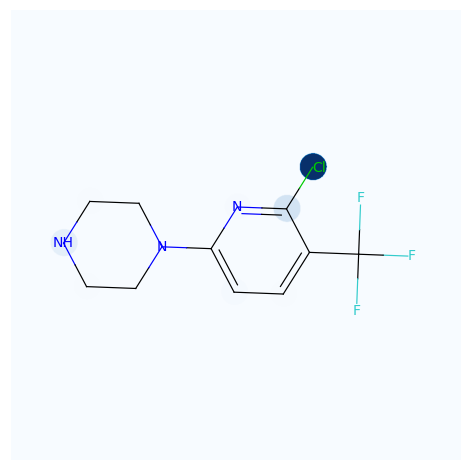

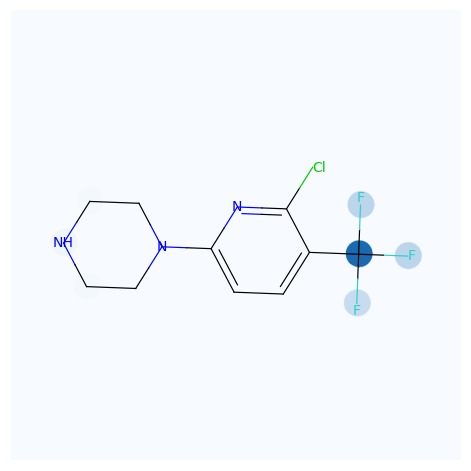

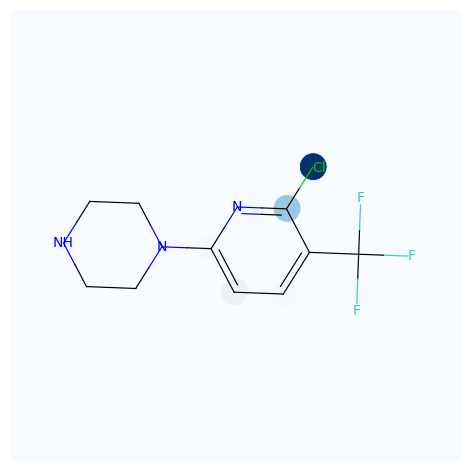

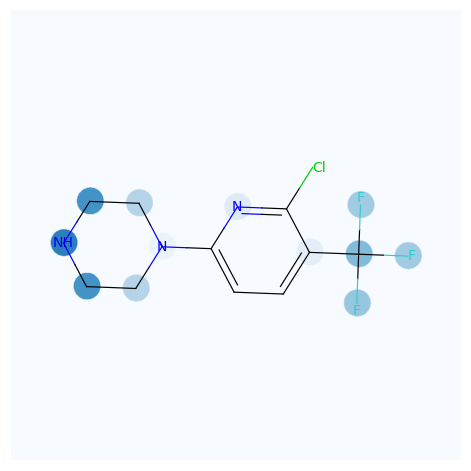

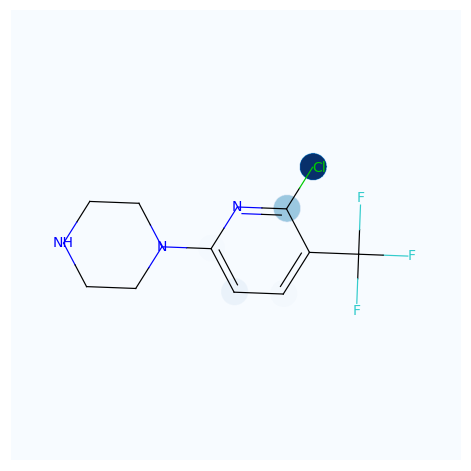

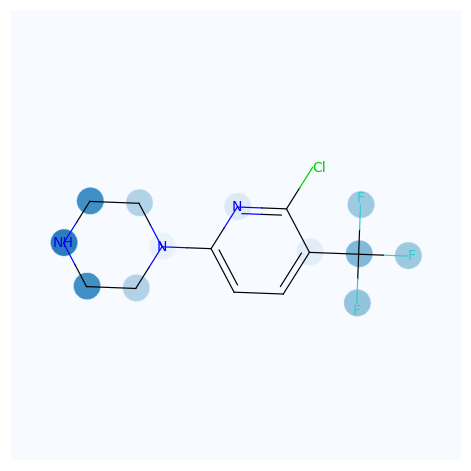

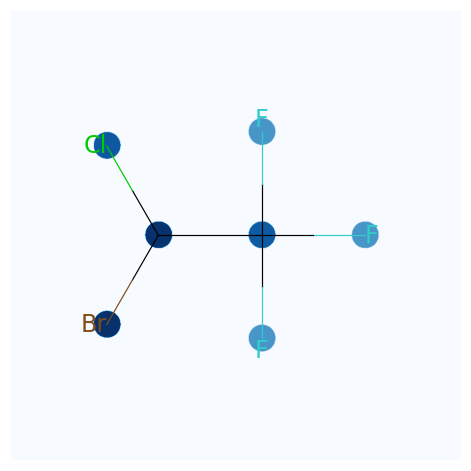

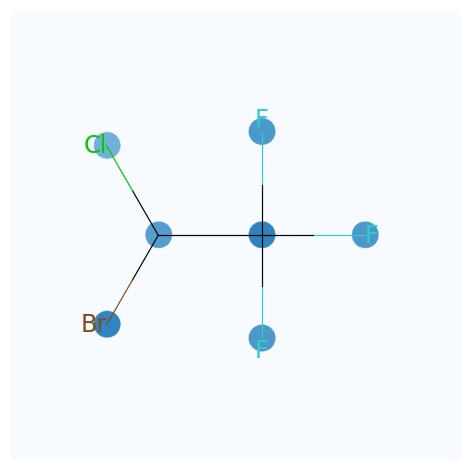

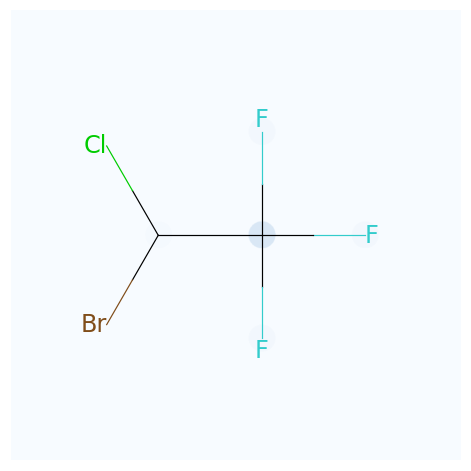

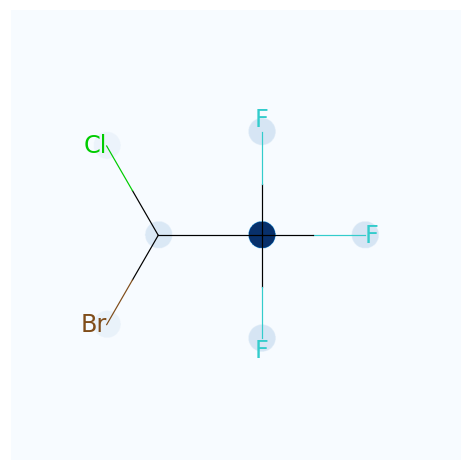

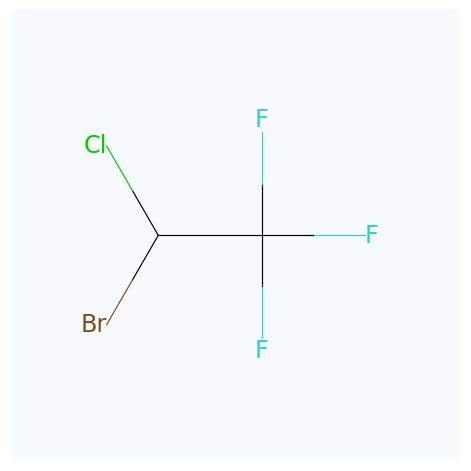

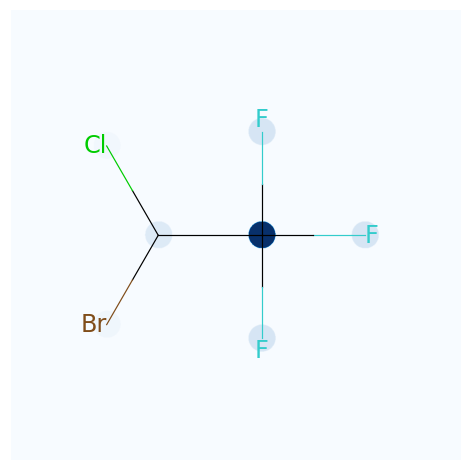

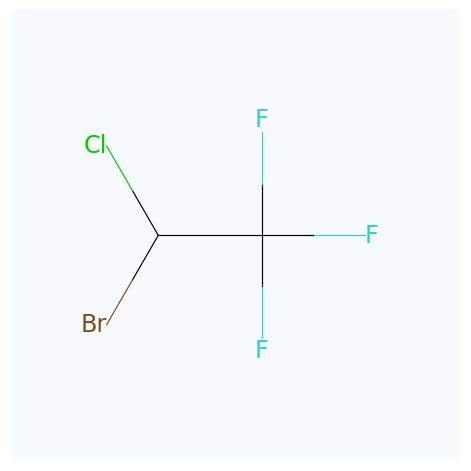

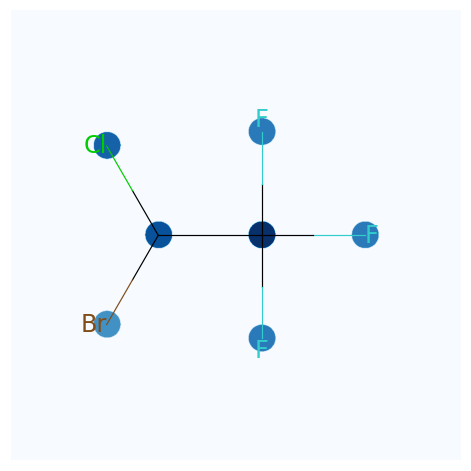

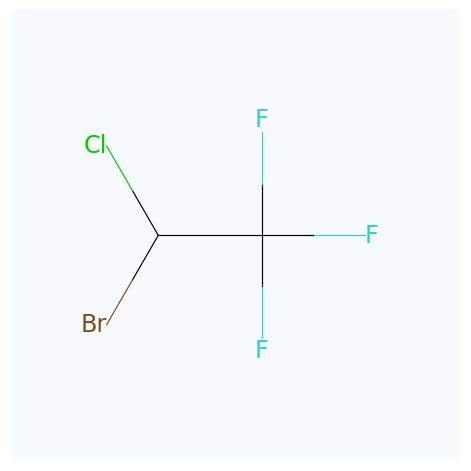

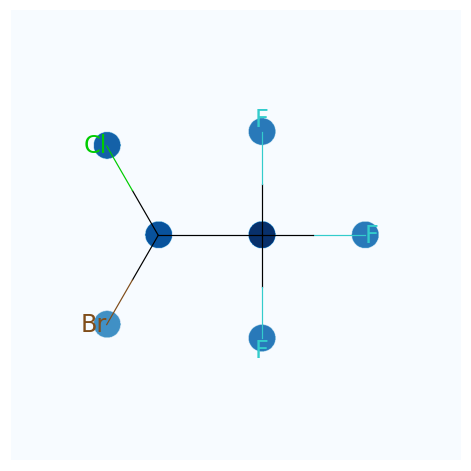

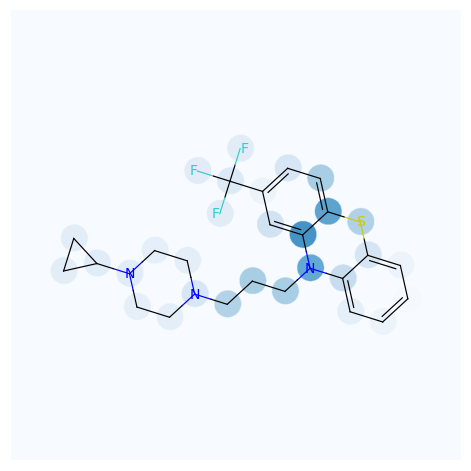

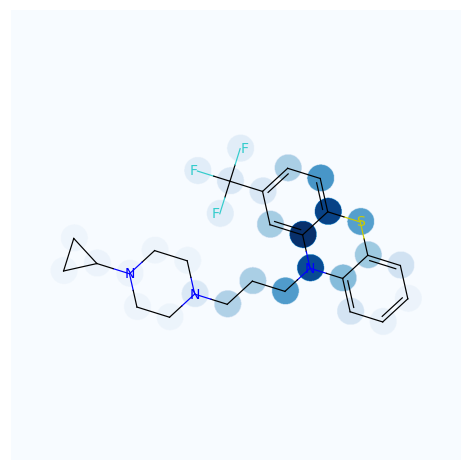

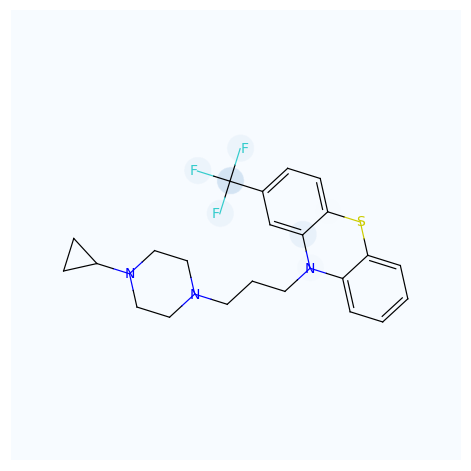

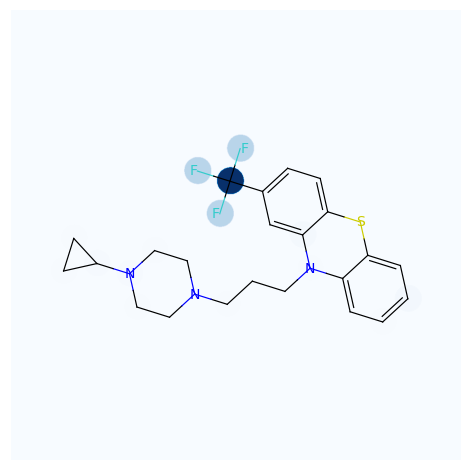

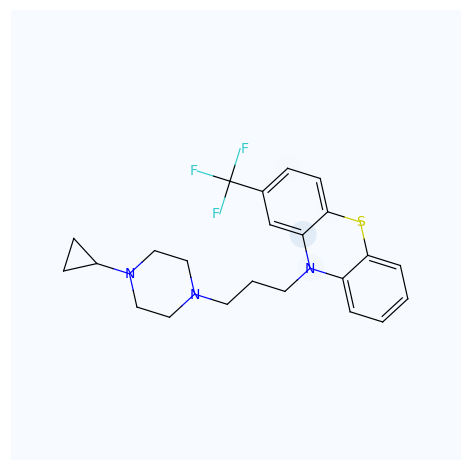

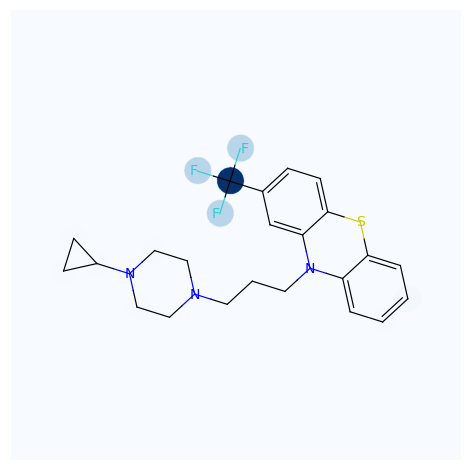

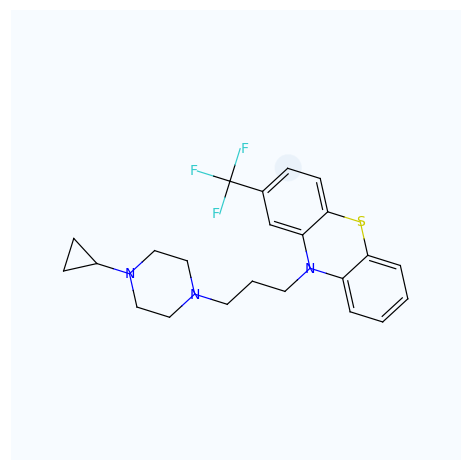

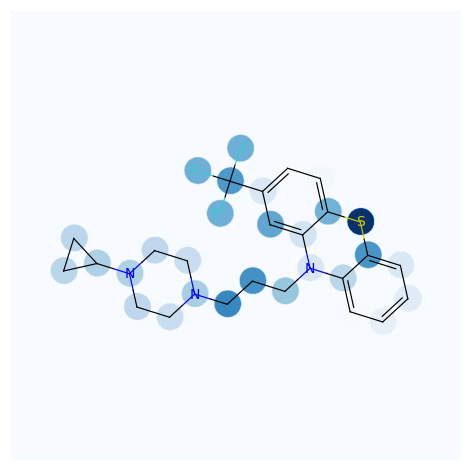

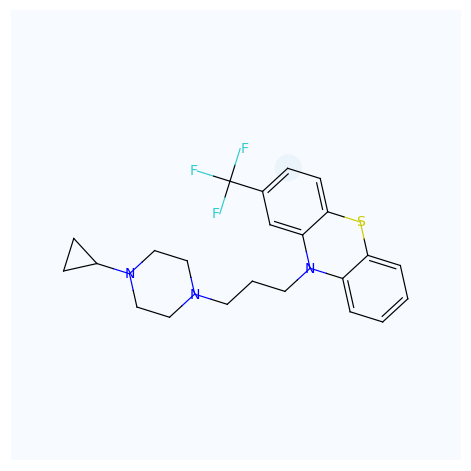

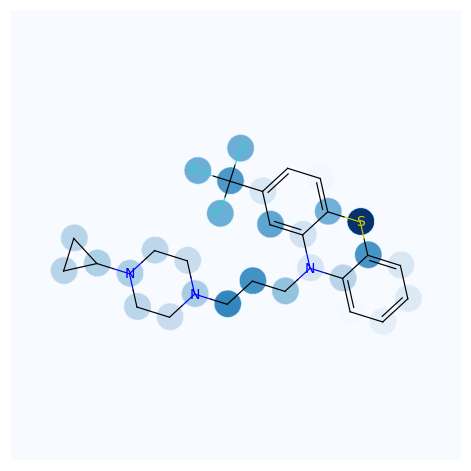

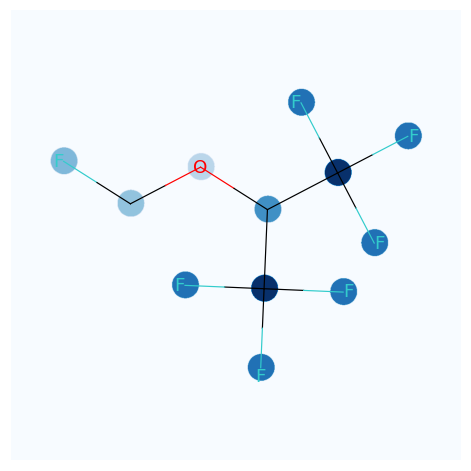

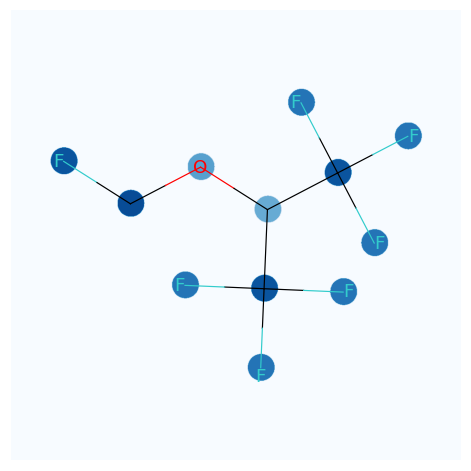

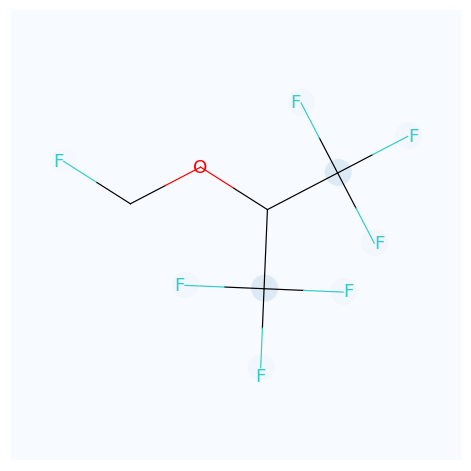

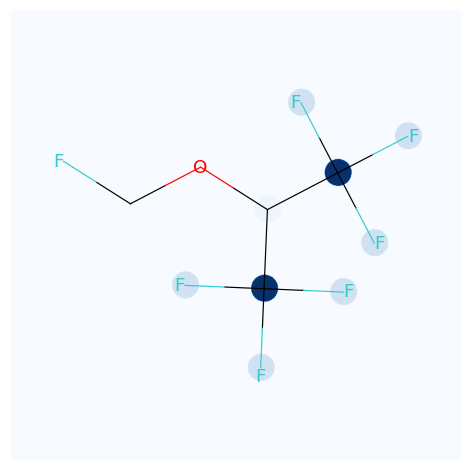

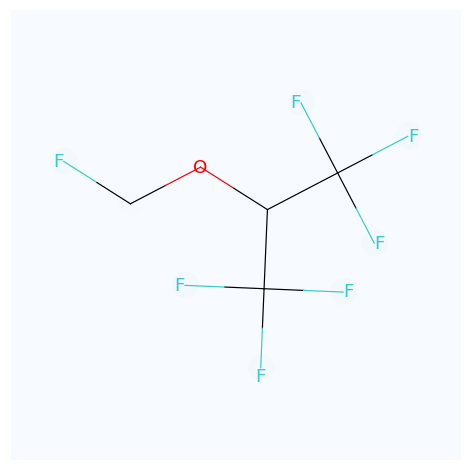

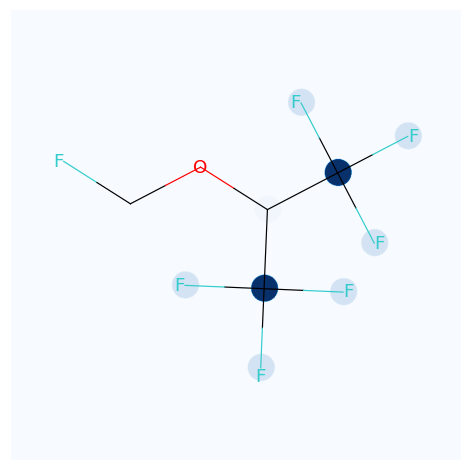

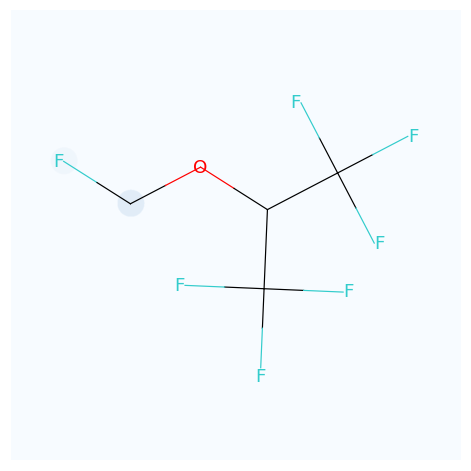

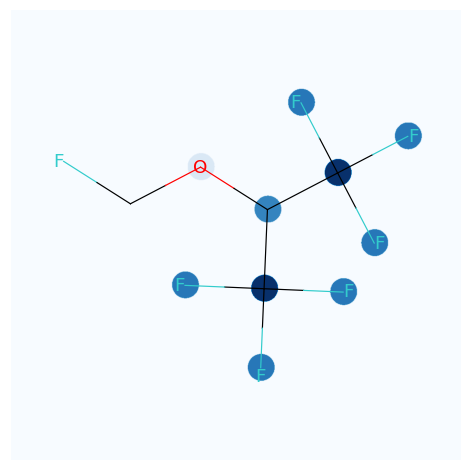

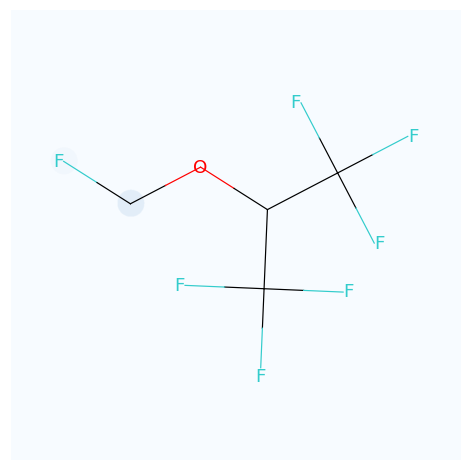

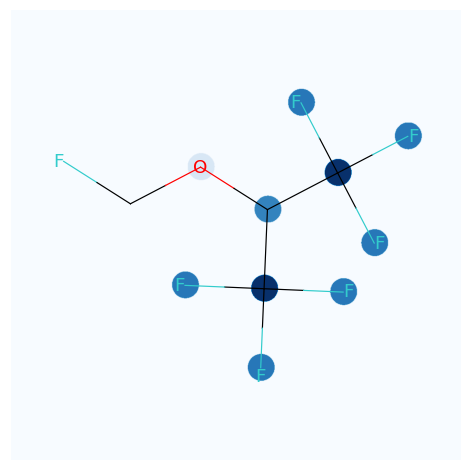

In [16]:
figs = create_figs(results)

In [17]:
ims_arr = create_im_arrs(figs)

<Figure size 432x288 with 0 Axes>

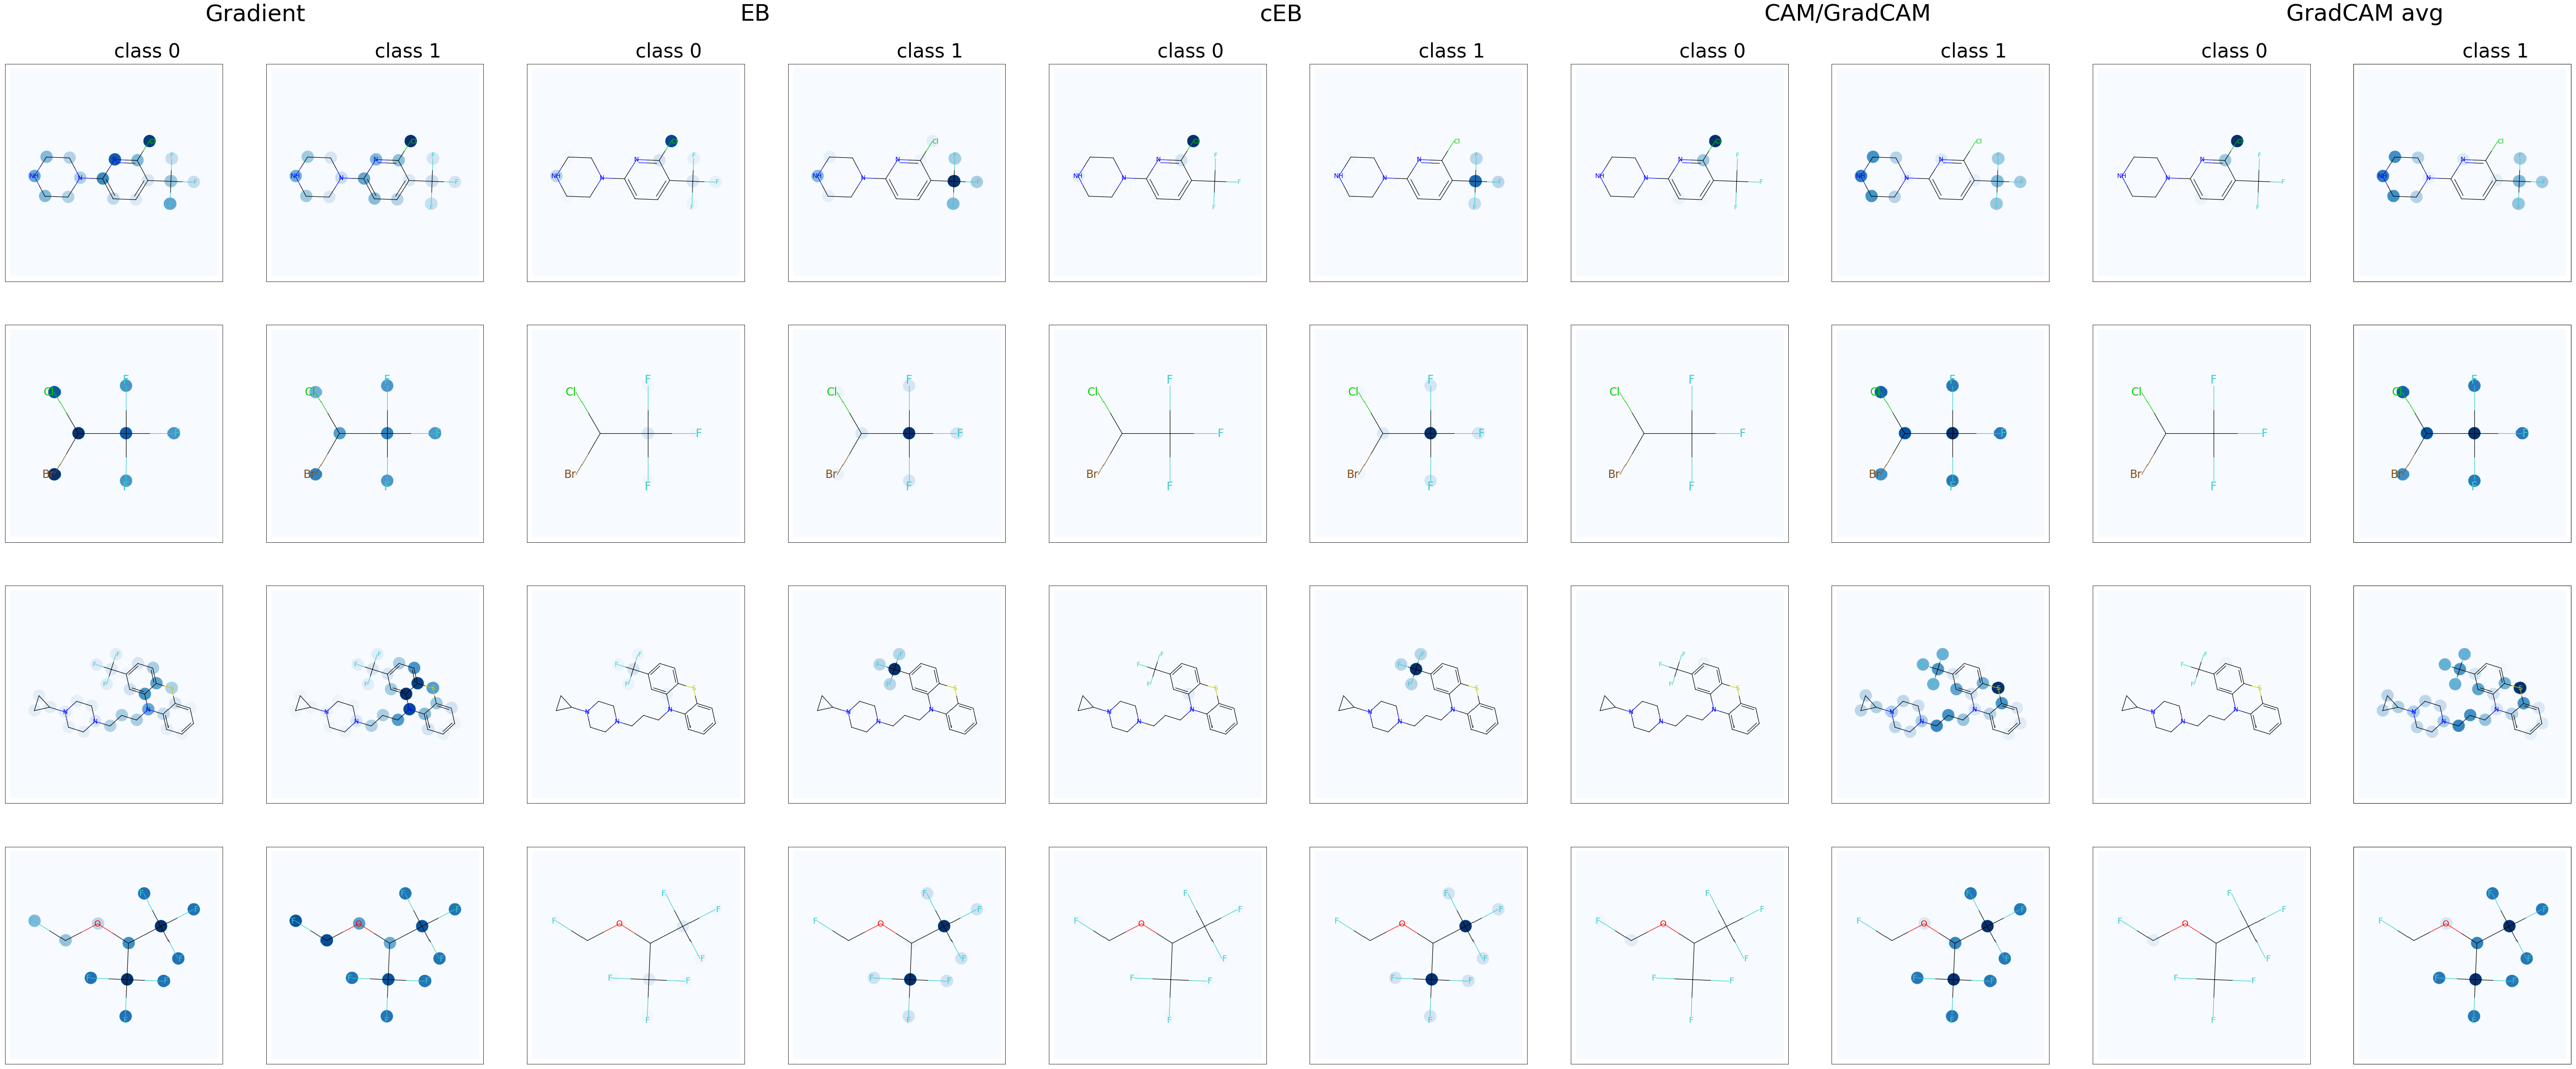

In [18]:
#Plot grid labels
label, prob, pred = zip(*text)
##Expanded labels
#row_labels_left = [('label: {}'.format(label[i]),'pred: {}'.format(pred[i])) for i in range(len(label))]
#row_labels_right = [(viz_smiles[i], 'prob: {}'.format(prob[i])) for i in range(len(label))]
row_labels_left = [("","") for i in range(len(label))]
row_labels_right = [("","") for i in range(len(label))]

super_col_labels = []
col_labels = []
for method in method_names:
    super_col_labels.append(method)
    col_labels.append("class 0")
    col_labels.append("class 1")

fig_dir = os.path.join(config["fig_dir"], dataset)

batch_size = min(15, len(viz_smiles))
num_batches = len(ims_arr) // batch_size
for i in range(num_batches):
    if save_fig:
        fig_fp = os.path.join(fig_dir, "{}.png".format(i))
    else:
        fig_fp = None
    plot_image_grid(ims_arr[i*batch_size:(i+1)*batch_size], 
                    row_labels_left[i*batch_size:(i+1)*batch_size], 
                    row_labels_right[i*batch_size:(i+1)*batch_size], 
                    col_labels,
                    super_col_labels,
                    dpi=224,
                    file_name=fig_fp, 
                    fontsize=35,
                    col_rotation=0)